In [59]:
import os
import re
import biom
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from biom import Table

In [60]:
table = biom.load_table("Data/table_filter.biom")

In [61]:
table

14093 x 210090 <class 'biom.table.Table'> with 25341594 nonzero entries (0% dense)

In [564]:
metadata = pd.read_csv("Data/metadata_filter.txt", sep="\t")

### get silve taxonomy

In [1133]:
tax = pd.read_csv("Data/taxmap_SILVA_138.2_SSURef_NR99.txt", 
                  sep="\t", header=None, names=["fid", "Taxonomy"])
# Split taxonomy into individual ranks
tax[['Kingdom', 'Phylum', 'Class', 
               'Order', 'Family', 'Genus']] = tax['Taxonomy'].str.split(';', expand=True)[[0, 1, 2, 3, 4, 5]]

# Remove taxonomic level prefixes (e.g., "k__")
for rank in ['Kingdom', 'Phylum', 'Class', 'Order', 'Family', 'Genus']:
    tax[rank] = tax[rank].str.replace(r'^\w__', '', regex=True)
tax = tax[['fid', 'Phylum', 'Class', 'Order', 'Family', 'Genus']]
tax = tax.set_index("fid")

In [1134]:
tax = tax.loc[table.ids(axis="observation")]

In [1135]:
tax.head()

,Phylum,Class,Order,Family,Genus
fid,,,,,
AAAA02020714.1.1202,Pseudomonadota,Alphaproteobacteria,Sphingomonadales,Sphingomonadaceae,Sphingomonas
AABY01000498.6.1303,Amorphea,Obazoa,Opisthokonta,Nucletmycea,Fungi
AAFJ01000001.39328.40836,Campylobacterota,Campylobacteria,Campylobacterales,Campylobacteraceae,Campylobacter
AAPY01395728.1.1201,Amorphea,Obazoa,Opisthokonta,Holozoa,Choanozoa
AAPY01395744.36.1258,Amorphea,Obazoa,Opisthokonta,Holozoa,Choanozoa


### reads频数图

In [4]:
import biom
table = biom.load_table("../../data/pretraining_data_table.biom")
sample_sums = table.sum(axis='sample')  # 按样本求和（即每列的和）

In [5]:
import pandas as pd
read_depth = pd.DataFrame({"sample_nums":sample_sums})
read_depth.to_csv("../../data/Pretraining_data_profile/read_depth_samples.csv", index=None, header=None)

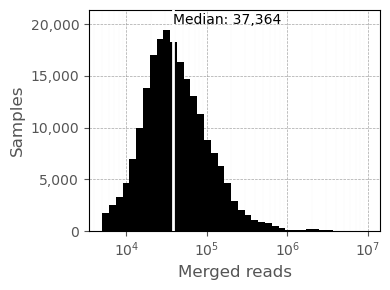

In [8]:
from matplotlib import ticker
from matplotlib import pyplot as plt
import numpy as np

plt.style.use('ggplot')  # ggplot风格
fig, ax = plt.subplots(figsize=(4, 3), facecolor='white')
ax.set_facecolor('white')  # 绘图区背景

# 计算统计量
median_reads = np.median(sample_sums)
min_reads = np.min(sample_sums)
max_reads = np.max(sample_sums)

# 生成分箱
bins = np.logspace(np.log10(min_reads), np.log10(max_reads), 40)

# 绘制直方图
n, bins, patches = ax.hist(sample_sums, bins=bins, color='black', edgecolor='none')

# 添加中位线
ax.axvline(median_reads, color='white', linestyle='-', linewidth=2,zorder=3)

# 添加注释
formatter = ticker.StrMethodFormatter("{x:,.0f}")  # 创建格式化器
max_n = max(n)  # 获取直方图最高频数
ax.set_ylim(top=1.1 * max_n)  # 扩展Y轴上限为最高频数的1.2倍
ax.text(x=median_reads, y=1.05*max(n),
    s=f'Median: {formatter(median_reads)}',  # 应用格式化器
    fontsize=10, color='black', ha='left', va='center'
)

# 坐标轴设置
ax.set_xscale('log')
ax.set_xlabel('Merged reads', fontsize=12)
ax.set_ylabel('Samples', fontsize=12)

# 网格线设置
ax.grid(which='major', axis='both', 
       linestyle='--', linewidth=0.5, 
       alpha=0.7, color='gray')  # 主网格
ax.grid(which='minor', axis='both', 
       linestyle=':', linewidth=0.3, 
       alpha=0.4, color='lightgray')  # 次网格

# 去除次刻度线
ax.tick_params(axis='x', which='minor', length=0, colors='white')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# 美化边框
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.8)

plt.tight_layout()
plt.savefig('./Figures/distribution.png',dpi = 300, bbox_inches='tight')
plt.show()

###  不同分类层级samples数统计

In [1142]:
sample_ids = table.ids(axis='sample') 

In [1143]:
def count_taxonomy_samples(level):
    """统计指定分类层级下各分类的样本数，处理未分类项"""
    # 替换缺失的分类信息为 (Unassigned)
    
    # 统计样本数
    level_counts = merged_df.groupby(level)[sample_ids].apply(
        lambda x: (x > 0).any(axis=0).sum()
    )
    return level_counts.to_frame(name=f"{level}_Samples")

# 按OTU合并丰度与分类信息
abundance_df = table.to_dataframe()
merged_df = abundance_df.merge(tax, left_index=True,right_index=True)

# 各层级统计
# 生成层次化结构数据
taxonomy_levels = ['Phylum', 'Class', 'Order', 'Family', 'Genus']
result_dfs = [count_taxonomy_samples(level) for level in taxonomy_levels]

In [1144]:
# 合并所有层级结果（保留未分类项）
final_df = pd.concat(result_dfs, axis=1, join='outer').fillna(0).astype(int)

# 按门级样本数排序
final_df.sort_values('Phylum_Samples', ascending=False, inplace=True)

# 预处理分类层级映射
taxonomy_mapping = {}
for level in ['Class', 'Order', 'Family', 'Genus']:
    mapping = (
        tax.groupby(level)['Phylum']
        .agg(lambda x: x.mode()[0] if not x.mode().empty else '(Unassigned)')
        .to_dict()
    )
    taxonomy_mapping[level] = mapping

In [1145]:
final_df.to_csv("Data/tax_num_samples.csv")
# 写入文件
with open("Data/taxonomy_mapping.json", "w", encoding="utf-8") as f:
    json.dump(taxonomy_mapping, f, ensure_ascii=False, indent=4)

/home/dongbiao/tmp/ipykernel_167057/3476425968.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


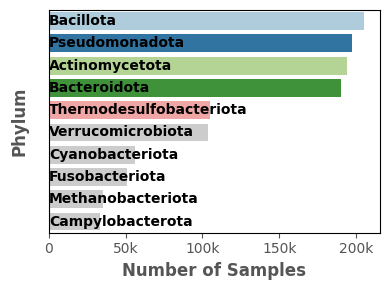

/home/dongbiao/tmp/ipykernel_167057/3476425968.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


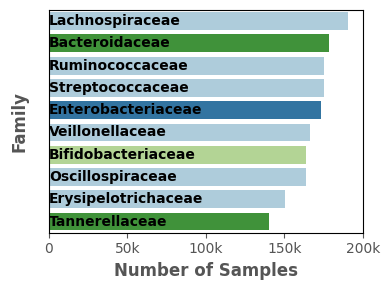

/home/dongbiao/tmp/ipykernel_167057/3476425968.py:33: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


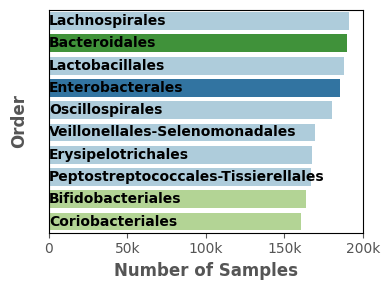

In [533]:
# 全局颜色配置
PHYLUM_COLORS = {}
TOP_PHYLA = []

def plot_top_taxa(level, top_n=10):
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(4, 3), facecolor='white')
    ax.set_facecolor('white')
    
    # 提取数据并清洗索引
    data = final_df[f'{level}_Samples'].sort_values(ascending=False).head(top_n)
    data.index = data.index.str.strip()  # 确保索引无多余空格
    
    # 颜色分配逻辑
    global PHYLUM_COLORS, TOP_PHYLA
    if level == 'Phylum':
        TOP_PHYLA = data.index[:5].tolist()
        phylum_palette = sns.color_palette("Paired", 5)
        PHYLUM_COLORS = {p: c for p, c in zip(TOP_PHYLA, phylum_palette)}
        colors = [PHYLUM_COLORS.get(p, '#CCCCCC') for p in data.index]
    else:
        colors = []
        color_mapper = taxonomy_mapping.get(level, {})
        for taxon in data.index:
            clean_taxon = taxon.strip().lower()  # 统一为小写处理
            phylum = color_mapper.get(
                taxon,  # 原始名称查询
                color_mapper.get(clean_taxon, '(Unassigned)')  # 小写名称查询
            )
            colors.append(PHYLUM_COLORS.get(phylum, '#CCCCCC'))
    
    # 绘制条形图
    ax = sns.barplot(
        x=data.values,
        y=data.index,
        palette=colors,
        orient='h'
    )
    
    # 坐标轴优化
    ax.yaxis.set_ticks([])
    plt.ylabel(level, 
             fontdict={'fontweight': 'bold', 'fontsize': 12},
             labelpad=15)
    
    # 添加分类标签
    for i, (value, name) in enumerate(zip(data.values, data.index)):
        ax.text(0.01, i, name, 
               ha='left', va='center', 
               fontsize=10, color='black',
               fontweight='bold')
    
    # 格式化x轴
    ax.xaxis.set_major_formatter(ticker.FuncFormatter(
        lambda x, _: f"{int(x/1000)}k" if x >= 1000 else f"{int(x)}"
    ))
    plt.xlim(0, data.max()*1.05)
    
    # 网格与边框
    ax.grid(which='major', axis='both', linestyle='--', alpha=0.7)
    ax.grid(which='minor', axis='both', linestyle=':', alpha=0.4)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.8)
    
    plt.xlabel('Number of Samples', fontweight='bold')
    plt.tight_layout()
    plt.savefig(f'{level}_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

# ================ 执行可视化 ================
if __name__ == "__main__":
    plot_top_taxa('Phylum')  # 必须先运行此初始化颜色
    plot_top_taxa('Family')
    plot_top_taxa('Order')

In [534]:
tax_reset = tax.reset_index(names=['fid'])

In [1156]:
top_phyla = final_df.index[:5].tolist()

In [1157]:
top_phyla

['Bacillota',
 'Pseudomonadota',
 'Actinomycetota',
 'Bacteroidota',
 'Thermodesulfobacteriota']

In [1146]:
# top 5 Phylum 样本丰度频数统计
# 获取前5大Phylum名称
top_phyla = final_df.index[:5].tolist()


# 合并OTU注释与丰度数据
phyla_abundance = abundance_df.merge(
    tax_reset[['fid', 'Phylum']],
    left_index=True,
    right_on='fid'
).drop(columns=['fid'])
# 按Phylum聚合丰度（使用分组求和）
phyla_abundance = phyla_abundance.groupby('Phylum').sum().T

phyla_abundance_tss = phyla_abundance.div(phyla_abundance.sum(axis=1), axis=0) * 100

# 筛选前5大Phylum并排序
phyla_abundance_top = phyla_abundance_tss[top_phyla]
phyla_abundance_top.head()

Phylum,Bacillota,Pseudomonadota,Actinomycetota,Bacteroidota,Thermodesulfobacteriota
10532.00954e18.1dcf.40fc.a52e.255f5cda6f9c,41.047359,0.543783,1.779653,56.026102,0.326270
10532.00cdbb86.acbd.429c.abe3.12f19990314a,22.157207,32.163058,0.000000,43.192900,0.692413
10532.00e6b118.fb6e.4022.96d1.62e553d9b40c,16.551861,44.025699,0.715327,37.336071,1.159094
10532.0129210b.a355.4608.8aac.7e6d637c0b5c,59.966865,0.831677,0.970842,35.530152,1.222664
10532.0476f5aa.a4f4.4835.ada1.4e72fb601e0a,77.030316,3.843771,3.518478,11.938482,0.030980


In [1158]:
phyla_abundance_top.to_csv("Data/phyla_abundance_top.csv")

In [1159]:
phyla_abundance_top

Phylum,Bacillota,Pseudomonadota,Actinomycetota,Bacteroidota,Thermodesulfobacteriota
10532.00954e18.1dcf.40fc.a52e.255f5cda6f9c,41.047359,0.543783,1.779653,56.026102,0.326270
10532.00cdbb86.acbd.429c.abe3.12f19990314a,22.157207,32.163058,0.000000,43.192900,0.692413
10532.00e6b118.fb6e.4022.96d1.62e553d9b40c,16.551861,44.025699,0.715327,37.336071,1.159094
10532.0129210b.a355.4608.8aac.7e6d637c0b5c,59.966865,0.831677,0.970842,35.530152,1.222664
10532.0476f5aa.a4f4.4835.ada1.4e72fb601e0a,77.030316,3.843771,3.518478,11.938482,0.030980
...,...,...,...,...,...
SRS9736998,83.150014,1.095846,1.894674,13.756391,0.000000
SRS9736999,66.896274,2.194702,1.461913,29.047741,0.287620
SRS9737000,62.049539,14.157969,0.843116,19.533476,1.426911
SRS9737001,73.966451,3.525706,2.131616,20.080204,0.260601


ValueError: autodetected range of [nan, nan] is not finite

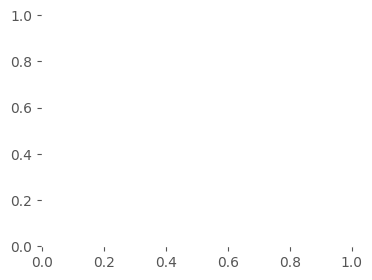

In [1155]:
# 设置全局参数
BINS = 30  # 分箱数量，控制曲线平滑度
LINE_WIDTH = 2.5

plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(4, 3), facecolor='white')
ax.set_facecolor('white')

# 生成统一的丰度分箱区间
all_values = phyla_abundance_top[top_phyla].values.flatten()
_, bin_edges = np.histogram(all_values, bins=BINS)

# 设置对数坐标系
ax.set_yscale('log')  

# 自定义Y轴格式
def log_format(y, pos):
    if  y >= 1e3:
        return f'{int(y/1e3)}k'  # 千单位
    else:
        return str(int(y))

# 应用格式器
ax.yaxis.set_major_formatter(ticker.FuncFormatter(log_format))
ax.yaxis.set_minor_formatter(ticker.NullFormatter())

# 绘制各Phylum分布曲线
for phylum in top_phyla:
    # 过滤零值样本
    values = phyla_abundance_top[phylum][phyla_abundance_top[phylum] > 0]
    
    # 计算分箱频数
    counts, _ = np.histogram(values, bins=bin_edges)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # 计算分箱中点
    
    ax.plot(bin_centers, counts,
           color=PHYLUM_COLORS[phylum],
           linewidth=LINE_WIDTH,
           marker='',
           label=f'{phylum} (n={len(values)})')

    
# 坐标轴设置
ax.xaxis.set_major_formatter(ticker.PercentFormatter(decimals=0))
ax.set_xlabel('Relative Abundance', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')

# 网格线设置
ax.grid(which='major', axis='both', 
       linestyle='--', linewidth=0.5, 
       alpha=0.7, color='gray')  # 主网格
ax.grid(which='minor', axis='both', 
       linestyle=':', linewidth=0.3, 
       alpha=0.4, color='lightgray')  # 次网格

# 去除次刻度线
ax.tick_params(
    axis='y', 
    which='minor', 
    length=0,          # 次刻度线长度设为0
    colors='white'     # 或设为透明色
)

# 美化边框
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.8)
    
plt.savefig('Relative_distribution.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()

### shanon 多样性 samples 频数统计

In [33]:
table

14116 x 210108 <class 'biom.table.Table'> with 25357065 nonzero entries (0% dense)

In [34]:
rarefied_biom = table.subsample(5000, by_id=False)

In [12]:
from skbio.diversity import alpha_diversity

In [35]:
# shanon 多样性计算
adiv_shannon = alpha_diversity('shannon', rarefied_biom.to_dataframe().T, rarefied_biom.ids(axis="sample"), base=np.e)
print(adiv_shannon.head(),adiv_shannon.median())

10532.00954e18.1dcf.40fc.a52e.255f5cda6f9c    3.496639
10532.00cdbb86.acbd.429c.abe3.12f19990314a    3.292231
10532.00e6b118.fb6e.4022.96d1.62e553d9b40c    2.569330
10532.0129210b.a355.4608.8aac.7e6d637c0b5c    4.087780
10532.0476f5aa.a4f4.4835.ada1.4e72fb601e0a    3.995244
dtype: float64 3.133833773074092


In [1]:
metadata = pd.read_csv("Data/metadata_filter.txt", sep="\t")

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


NameError: name 'pd' is not defined

In [ ]:
# Step 1: 设置索引为 sample_id
metadata = metadata.set_index("sample_id")

# Step 2: 赋值
sample_ids = rarefied_biom.ids(axis="sample")
metadata.loc[sample_ids, "shannon"] = adiv_shannon

# Step 3: 恢复索引（可选）
# metadata_reindex = metadata_reindex.reset_index()
metadata.head()

In [31]:
metadata = metadata.loc[sample_ids]
metadata["read_depth"] = sample_sums
metadata.to_csv("meta_data_include_shannon.csv", index=None)

In [32]:
metadata.shape

(210108, 8)

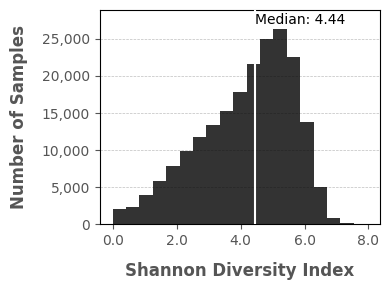

In [542]:
plt.style.use('ggplot')  # 使用ggplot风格
fig, ax = plt.subplots(figsize=(4, 3), facecolor='white')
ax.set_facecolor('white')  # 绘图区背景

adiv_shannon = metadata_reindex["shannon"].values
# 计算统计量
median_shannon = np.median(adiv_shannon)
min_shannon = np.min(adiv_shannon)
max_shannon = np.max(adiv_shannon)

# 生成分箱（改用线性分箱）
bins = np.linspace(min_shannon, 
                  max_shannon, 
                  20)  # 减少分箱数量到20

# 绘制直方图（优化颜色和边框）
n, bins, patches = ax.hist(
    adiv_shannon,
    bins=bins,
    color='black',
    edgecolor='none',  # 去除黑色边框
    linewidth=0.5,
    alpha=0.8
)

# 添加中位线（增强可视性）
median_line = ax.axvline(
    median_shannon,
    color='white',  
    linestyle='-',    
    linewidth=1.5,
    zorder=3
)

max_n = max(n)  # 获取直方图最高频数
ax.set_ylim(top=1.1 * max_n)  # 扩展Y轴上限为最高频数的1.2倍

# 添加统计标注（优化位置和样式）
ax.text(
    x=median_shannon ,  
    y=1.05*max(n),
    s=f'Median: {median_shannon:.2f}',
    fontsize=10,
    color='black',
    ha='left',
    va='center'
)

# 坐标轴设置
ax.set_xlabel('Shannon Diversity Index', 
             fontsize=12, 
             fontweight='bold',
             labelpad=10)
ax.set_ylabel('Number of Samples', 
             fontsize=12, 
             fontweight='bold',
             labelpad=10)

# 刻度格式优化
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.1f}"))  # X轴保留1位小数
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))  # Y轴添加千分位  

# 刻度参数设置
ax.tick_params(axis='both', which='major', labelsize=10)
ax.tick_params(axis='both', which='major', labelsize=10)


# 网格线优化
ax.grid(
    which='major',
    axis='y',
    linestyle='--',
    linewidth=0.5,
    alpha=0.5,
    color='gray'
)

# 边框美化
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(0.8)

plt.tight_layout()
plt.savefig('shannon_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### prevalence

In [67]:
table = biom.load_table("Data/table_filter.biom")

In [69]:
fid = table.ids(axis="observation")

In [70]:
import matplotlib.ticker as ticker
# 处理原始数据中的0值
prevalence = table.nonzero_counts(axis="observation") / table.shape[1]

In [71]:
OTU_prevalence_abundance = pd.DataFrame({"OTU":fid, "prevalence":prevalence, "mean_abc":fid_abc_mean})

In [72]:
OTU_prevalence_abundance.to_csv("Data/OTU_prevalence_abundance.csv")

Text(0, 0.5, 'Density')

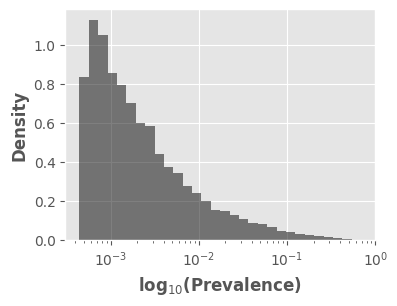

In [1169]:
plt.figure(figsize=(4, 3), facecolor='white')
plt.style.use('ggplot')
ax = sns.histplot(
    x=prevalence,
    stat='density',
    log_scale=True,
    color='black',
    alpha=0.5,
    kde=False,
    bins=30,
    edgecolor='none'
)

# 设置坐标轴范围和标签
ax.set_xlabel('log$_{10}$(Prevalence)', fontsize=12, fontweight='bold')
ax.set_ylabel('Density', fontsize=12, fontweight='bold')

In [1170]:
prevalence = pd.DataFrame({"prevalence":prevalence})
prevalence.to_csv("Data/prevalence.csv", index=None)